In [1]:
import import_ipynb

from keras.models import load_model

from control_data import *
from corr_pred import data_corr, pred_days
from make_df import merge_list
from modeling import *

Using TensorFlow backend.
importing Jupyter notebook from control_data.ipynb
importing Jupyter notebook from corr_pred.ipynb
importing Jupyter notebook from make_df.ipynb
importing Jupyter notebook from modeling.ipynb


In [2]:
# lg_data = get_data(2500, '066570', '066570')
lg_data = pd.read_csv('data/066570.csv', index_col = 0)
lg_data

,종가,거래량,기관매매량,외국인매매량,외국인보유율
2009-12-04,115500.0,2173892.0,148804.0,441274.0,27.64
2009-12-07,116500.0,1480237.0,-178243.0,455106.0,27.94
2009-12-08,116500.0,1052500.0,-103475.0,254921.0,28.11
2009-12-09,117500.0,1060857.0,-109753.0,138751.0,28.21
2009-12-10,117500.0,1484562.0,-150623.0,70291.0,28.26
...,...,...,...,...,...
2020-01-17,69200.0,464204.0,-89757.0,11089.0,33.77
2020-01-20,71200.0,894609.0,89928.0,249277.0,33.94
2020-01-21,70100.0,379059.0,-30571.0,-17604.0,34.09
2020-01-22,70400.0,546215.0,64709.0,-73675.0,34.08


In [3]:
df = lg_data
corr = data_corr(df, y = -1)
corr

['y: 외국인보유율',
 'x: 종가',
 LinregressResult(slope=0.00019754502625637797, intercept=11.269676308608796, rvalue=0.573299174699053, pvalue=1.9316448402787148e-218, stderr=5.64879696093616e-06)]

In [4]:
x_train, x_test, y_train, y_test = set_data(df, window_sizer = 20, test_rate = 0.1)
prices, foreign_rate, p_figs, a_figs = set_data(df, values = True)

In [5]:
model = price_pred_model(
    save = True, window_sizer = 20, filename = '20.02.12_dropout', lstm = 3, dropout_rate = .5)
# model = load_model('data/20.02.12_dropout_unfitted.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 2)             40        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 64)            17152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

Train on 2008 samples, validate on 224 samples
Epoch 1/20
2008/2008 [==============================] - 193s 96ms/step - loss: 0.1948 - val_loss: 0.4327
Epoch 2/20
2008/2008 [==============================] - 250s 125ms/step - loss: 0.1327 - val_loss: 0.0871
Epoch 3/20
2008/2008 [==============================] - 272s 135ms/step - loss: 0.1159 - val_loss: 0.1788
Epoch 4/20
2008/2008 [==============================] - 239s 119ms/step - loss: 0.0972 - val_loss: 0.2107
Epoch 5/20
2008/2008 [==============================] - 230s 115ms/step - loss: 0.0928 - val_loss: 0.1947
Epoch 6/20
2008/2008 [==============================] - 219s 109ms/step - loss: 0.0789 - val_loss: 0.1461
Epoch 7/20
2008/2008 [==============================] - 231s 115ms/step - loss: 0.0835 - val_loss: 0.0837
Epoch 8/20
2008/2008 [==============================] - 223s 111ms/step - loss: 0.0800 - val_loss: 0.0866
Epoch 9/20
2008/2008 [==============================] - 226s 112ms/step - loss: 0.0754 - val_loss: 0.0663


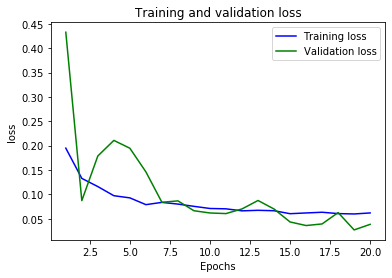

In [6]:
fit = model_fit(
    model, x_train, y_train, val_rate = 0.1, save = True, img_save = True, filename = '20.02.12_dropout', epochs = 20)
fit = load_model('data/20.02.12_dropout_fitted.h5')

In [7]:
train_pred = to_1d_list(fit.predict(x_train))
test_pred = to_1d_list(fit.predict(x_test))

d_train_pred = denormalize(train_pred, p_figs)
d_test_pred = denormalize(test_pred, p_figs)
d_last_pred = pred_days(
    fit, prices, foreign_rate, p_figs, a_figs, corr[2][:2], days = 6, window_sizer = 20)

d_test_pred_added = [d_train_pred[-1]] + d_test_pred + [d_last_pred[0][0]]
d_last_pred = d_last_pred[0]

empty = len(prices) - (len(d_train_pred) + len(d_test_pred))

print(len(d_train_pred), len(d_test_pred_added), empty)

2232 250 20


In [8]:
result_df = merge_list(
    df, empty, prices, d_train_pred, d_test_pred_added, d_last_pred, len(d_test_pred_added))

result_df

,real,trained,tested,pred
2009-12-04,115500.0,NaN,NaN,NaN
2009-12-07,116500.0,NaN,NaN,NaN
2009-12-08,116500.0,NaN,NaN,NaN
2009-12-09,117500.0,NaN,NaN,NaN
2009-12-10,117500.0,NaN,NaN,NaN
...,...,...,...,...
D+1,NaN,NaN,NaN,75890.0
D+2,NaN,NaN,NaN,84700.0
D+3,NaN,NaN,NaN,87500.0
D+4,NaN,NaN,NaN,86930.0


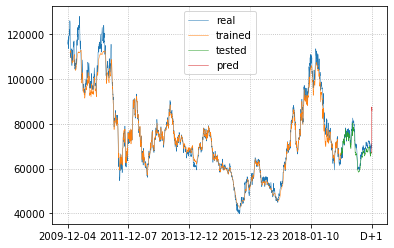

In [9]:
result_df.plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.autoscale(tight = False)

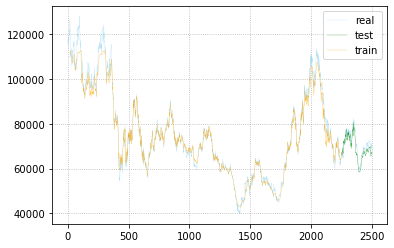

In [21]:
plt.plot(list(result_df[result_df.columns[0]]), 'skyblue', linewidth = '.3', alpha = 0.6)
plt.plot(list(result_df[result_df.columns[2]]), 'green', linewidth = '.3', alpha = 0.8)
plt.plot(list(result_df[result_df.columns[1]]), 'orange', linewidth = '.3', alpha = 0.8)
# plt.plot(list(result_df[result_df.columns[3]]), 'red', linewidth = '.3', alpha = 0.2)
# x축 idx 수정 가능한지?
plt.grid(ls = ':')
plt.legend(['real', 'test', 'train', 'pred'])

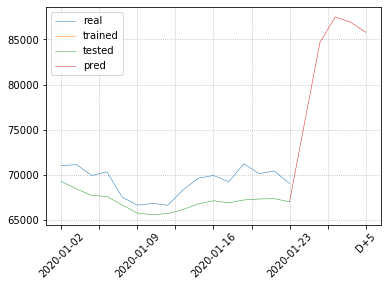

In [11]:
result_df['2019-12.31':].plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.xticks(rotation = 45)
plt.autoscale(tight = False)